In [167]:
%matplotlib widget
import numpy as np
import seaborn as sns
import pandas as pd
from glob import glob
from functools import reduce
from tqdm import tqdm
from collections import defaultdict
from scipy import stats
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
import os

In [168]:
# from dotenv import load_dotenv
# load_dotenv()

# ROOTPATH = os.getenv("ROOTPATH")
# BONEPATH = os.getenv("BONEPATH")
# LIBPATH = os.path.join(ROOTPATH, "lib")

In [169]:
def load_csv(path):
    return pd.read_csv(path)

In [170]:
def calculate_pi(data, p=0.95):
    """
    Calculate the 95% prediction interval for the given data.

    Parameters:
    data (array-like): A list or array of numerical data points.

    Returns:
    dict: Lower and upper bounds of the 95% prediction interval.
    """
    # Calculate mean and standard error of the mean
    mean = np.mean(data)
    std = np.std(data, ddof=1)

    # Number of observations
    n = len(data)

    bounds = {}
    for conf in [0.95, 0.99, 0.999]:
        t_score = stats.t.ppf((1 + conf) / 2., n-1)
        margin_of_error = t_score * std * np.sqrt(1 + 1/n)
        bounds[str(conf)] = {
            "lower": mean - margin_of_error,
            "upper": mean + margin_of_error,
        }

    return bounds

def calculate_pi_range(data):
    """
    Calculate the 95%, 99%, 99.9%, and 99.99% prediction interval for the given data.

    Parameters:
    data (pd.DataFrame): Rand_rstats dataframe containing radius, K(r) value, and simulation number
                         columns

    Returns:
    dict: Lower and upper bounds of the prediction intervals.
    """
    radii = data[data["Line"] == 1]["Radius (r)"].tolist()
    
    bounds = {}
    for radius in radii:
        subset = data[data["Radius (r)"] == radius]["K(r)"].tolist()

        # Calculate mean and standard error of the mean
        mean = np.mean(subset)
        std = np.std(subset, ddof=1)

        # Number of observations
        n = len(subset)

        bounds[radius] = {}
        for conf in [0.95, 0.99, 0.999, 0.9999]:
            t_score = stats.t.ppf((1 + conf) / 2., n-1)
            margin_of_error = t_score * std * np.sqrt(1 + 1/n)
            bounds[radius][str(conf)] = {
                "lower": mean - margin_of_error,
                "upper": mean + margin_of_error,
            }
    return bounds

def calculate_percentile_range(data):
    """
    Calculate the 95%, 99%, 99.9%, and 99.99% percentile intervals for the given data.

    Parameters:
    data (pd.DataFrame): DataFrame containing 'Radius (r)', 'K(r) value', and possibly 
                         'simulation number' columns.

    Returns:
    dict: Lower and upper bounds of the percentile intervals for each radius.
    """
    radii = data[data["Line"] == 1]["Radius (r)"].tolist()
    
    bounds = {}
    for radius in radii:
        subset = data[data["Radius (r)"] == radius]["K(r)"].tolist()

        # Define the confidence levels and their corresponding percentile values
        percentiles = {
            0.95: (2.5, 97.5),
            0.99: (0.5, 99.5),
            0.999: (0.05, 99.95),
            0.9999: (0.005, 99.995)
        }

        bounds[radius] = {}
        for conf, (lower_perc, upper_perc) in percentiles.items():
            lower_bound = np.percentile(subset, lower_perc)
            upper_bound = np.percentile(subset, upper_perc)
            bounds[radius][str(conf)] = {
                "lower": lower_bound,
                "upper": upper_bound,
            }
    
    return bounds

def get_equivalent_color(cf, alpha, cb=(255, 255, 255)):
    """
    Calculate the RGB values of an opaque color in decimal format (0-1) that visually matches a semi-transparent color
    when placed over a specified background color. This function automatically handles both regular RGB (0-255) and
    decimal RGB (0-1) formats for the input colors.

    Parameters:
    - cf (tuple): The foreground color in RGB format, either in regular (0-255) or decimal (0-1).
    - alpha (float): The alpha transparency level of the foreground color, ranging from 0 (completely transparent)
      to 1 (completely opaque).
    - cb (tuple, optional): The background color in RGB format, either in regular (0-255) or decimal (0-1). Defaults to white (255, 255, 255).

    Returns:
    - list of float: The RGB values of the equivalent opaque color in decimal format that visually matches the semi-transparent
      foreground color when viewed against the background color.

    Example:
    >>> get_equivalent_color((0, 0, 255), 0.5)
    [0.5, 0.5, 1.0]
    """
    # Check if the input colors are in the regular RGB (0-255) format and convert them to decimal format if necessary
    cf_decimal = [f / 255. if max(cf) > 1 else f for f in cf]
    cb_decimal = [b / 255. if max(cb) > 1 else b for b in cb]

    # Calculate the equivalent color in decimal RGB format
    result_decimal = [alpha * f + (1 - alpha) * b for f, b in zip(cf_decimal, cb_decimal)]

    return result_decimal
    
def pi_range_to_df(data: dict):
    """
    Converts a nested dictionary containing radius, confidence intervals ('pi'), and their corresponding
    lower and upper bounds into a pandas DataFrame.

    Parameters:
    - data (dict): A nested dictionary where the first level keys are radii, the second level keys are
      confidence intervals (e.g., '0.95'), and the values are dictionaries with 'lower' and 'upper' bounds.

    Returns:
    - pandas.DataFrame: A DataFrame with columns for 'radius', 'pi' (confidence interval), 'lower', and 'upper' bounds.

    Example:
    >>> data = {1: {'0.95': {'lower': 0, 'upper': 10}, '0.99': {'lower': -5, 'upper': 15}}}
    >>> pi_range_to_df(data)
    # Returns a DataFrame with each row representing a combination of radius, pi, lower, and upper values.
    """
    # Flatten the dictionary into a list of rows
    rows = []
    for radius, pi in data.items():
        for pi, bounds in pi.items():
            rows.append({
                "radius": radius,
                "pi": pi,
                "lower": bounds["lower"],
                "upper": bounds["upper"],
            })

    # Convert the list of rows into a DataFrame
    return pd.DataFrame(rows)

def plot_interval(df, color, ax, pi="0.95"):
    """
    Plots confidence intervals (lower and upper bounds) for a specified 'pi' value from a DataFrame
    onto a given axis ('ax'), including filling the area between these bounds.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data to plot, expected to have columns
      'radius', 'pi', 'lower', and 'upper'.
    - color (str): The color to use for both lines and the fill between them.
    - ax (matplotlib.axes.Axes): The Matplotlib axis object where the plot will be drawn.
    - pi (str, optional): The confidence interval level to plot (e.g., '0.95'). Defaults to '0.95'.

    Returns:
    - None: This function plots on the provided Matplotlib axis and does not return a value.

    Example:
    >>> plot_interval(df, 'blue', ax, pi="0.99")
    # This will plot the lower and upper bounds for the '0.99' confidence interval on the provided axis.
    """
    for col_name in ["lower", "upper"]:
        sns.lineplot(
            data=df[df["pi"] == pi],
            x="radius",
            y=col_name,
            color=get_equivalent_color(color, 0.4),
            linewidth=0.5,
            ax=ax,
        )
    
    # Now, fill between the lines
    # Extracting the 'radius', 'lower', and 'upper' values for the "0.95" confidence interval
    radii = df[df["pi"] == pi]["radius"]
    lower = df[df["pi"] == pi]["lower"]
    upper = df[df["pi"] == pi]["upper"]

    # Filling between the 'lower' and 'upper' lines on the second subplot
    ax.fill_between(radii, lower, upper, color=get_equivalent_color(color, 0.2))  # Adjust the color and alpha as needed
    return mpatches.Patch(color=get_equivalent_color(color, 0.2), label=f"{float(pi)*100}% Interval")


def plot_background_intervals(df, color, ax):
    max_pi = str(df["pi"].astype(float).max())

    # Extracting the 'radius', 'lower', and 'upper' values for the specified confidence interval
    radii = df[df["pi"] == max_pi]["radius"]
    lower = df[df["pi"] == max_pi]["lower"]
    upper = df[df["pi"] == max_pi]["upper"]

    # Get current y-axis limits
    ymin, ymax = ax.get_ylim()

    # Filling from the bottom of the graph to the bottom-most line
    ax.fill_between(radii, ymin, lower, color=get_equivalent_color(color, 0.2))

    # Filling from the top of the graph to the topmost line
    ax.fill_between(radii, upper, ymax, color=get_equivalent_color(color, 0.2))
    return mpatches.Patch(color=get_equivalent_color(color, 0.2), label=f">99.99% Interval")

# Example usage
# data = rand_rstats[rand_rstats["Radius (r)"] == 50]["H(r)"].tolist()
# lower_bound, upper_bound = calculate_pi(data)
# print("95% Confidence Interval:", lower_bound, "to", upper_bound)


In [171]:
# For testing only
rstats_path = "/home/dkermany/ripley_results/FV10__20181004_122358_random_multivariate_ng2_tvc_rstats.csv"
rand_rstats = load_csv(rstats_path)

pi_range_to_df(calculate_pi_range(rand_rstats))



,radius,pi,lower,upper
0,2,0.95,0.000000e+00,0.000000e+00
1,2,0.99,0.000000e+00,0.000000e+00
2,2,0.999,0.000000e+00,0.000000e+00
3,2,0.9999,0.000000e+00,0.000000e+00
4,3,0.95,0.000000e+00,0.000000e+00
...,...,...,...,...
387,98,0.9999,1.077073e+07,1.629272e+07
388,99,0.95,1.243646e+07,1.515297e+07
389,99,0.99,1.199687e+07,1.559257e+07
390,99,0.999,1.147312e+07,1.611632e+07


In [172]:
def normalize(rstats, rand_rstats):
    def min_max(data, min_val, max_val):
        """
        Normalize the data to have a lower bound of -1 and upper bound of 1
        with respect to the 95% interval min and max values
    
        Parameters:
        data (array-like): A list or array of numerical data points.
        min_val (float): min value
        max_val (float): max value
    
        Returns:
        array: Normalized data with bounds [-1, 1].
        """
        normalized_data = 2 * ((data - min_val) / (max_val - min_val)) - 1
        return normalized_data

    normalized_K = []
    for radius in rstats["Radius (r)"]:
        subset = rand_rstats[rand_rstats["Radius (r)"] == radius]["K(r)"].tolist()
        bounds = calculate_pi(subset)
        lower_bound_95, upper_bound_95 = bounds["0.95"]["lower"], bounds["0.95"]["upper"]
        if abs(lower_bound_95 - upper_bound_95) < 1:
            val = 0.
        else:
            val = min_max(rstats[rstats["Radius (r)"] == radius]["K(r)"].tolist()[0], lower_bound_95, upper_bound_95)
        normalized_K.append(val)
    return normalized_K

# print(normalize(66.77, lower_bound, upper_bound))

In [173]:
def draw_normalized_graph(rstats, rand_rstats, ax, title=None, ylabel=None):
    normalized_K = normalize(rstats, rand_rstats)

    rstats["normalized_K"] = normalized_K
    # Set the tick label format to plain
    plt.ticklabel_format(style="plain")
    
    # Update the font size for the plot
    plt.rcParams.update({"font.size": 20})
    
    # Create a subplot with 3 rows and 1 column
    # ax = plt.figure(figsize=(7,7))
    
    # Plot the K(r) values for the data and the random data
    sns.lineplot(data=rstats[["Radius (r)", "normalized_K"]], x="Radius (r)", y="normalized_K", zorder=3, ax=ax)
    
    # # Get the current x-axis limits after plotting the data
    # ax = plt.gca()
    xlims = ax.get_xlim()
    
    # Get the current y-axis limits after plotting the data
    ylims = ax.get_ylim()
    
    # Fill between y=1 and y=-1, extending to the edges of the graph
    ax.fill_between(xlims, -1, 1, color='#ffe5ce', alpha=0.9)
    
    # Adding thicker lines for the top and bottom borders, extending to the edges
    ax.hlines(1, *xlims, colors='#ffbb80', linewidth=1.5)
    ax.hlines(-1, *xlims, colors='#ffbb80', linewidth=1.5)
    
    # Set the x and y-axis limits to ensure the fill and borders extend to the edges
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    ax.set(xlabel="")
    ax.set(ylabel="")

    # Manually set the y-axis limits to include the -1 to 1 range
    max_val = max(rstats["normalized_K"])
    min_val = min(rstats["normalized_K"])
    
    new_ylims = (min(-1-(0.05*max_val), min_val), max(1+(0.05*max_val), max_val))  # This includes both your data and the -1 to 1 interval
    # print(rstats)
    # pprint(rand_rstats["K(r)"].tolist())
    print("new ylims", new_ylims)
    ax.set_ylim(new_ylims)

    ax.title.set_text(title)
    # plt.title()

In [174]:
def plot_ripley(rstats, rand_rstats, ax, title=None, pi=95):
    # Update the font size for the plot
    plt.rcParams.update({"font.size": 20})

    # Plot the K(r) values for the data and the random data
    # sns.lineplot(data=rstats, x="Radius (r)", y="K(r)", ax=ax[0])
    sns.lineplot(data=rand_rstats, x="Radius (r)", y="K(r)", hue="Line", ax=ax, alpha=1)
    ax.set(xlabel="")
    
    # Plot the L(r) values for the data and the random data
    # sns.lineplot(data=rstats, x="Radius (r)", y="L(r)", ax=ax[1])
    # sns.lineplot(data=rand_rstats, x="Radius (r)", y="L(r)", ax=ax[1], alpha=0, errorbar=("pi", pi))
    
    # Add a line representing the expected L(r) values
    # ax[1].plot([0, 100], [0, 100], linewidth=1, linestyle="dotted", color="#aaa") 
    # ax[1].set(xlabel="")
    
    # Plot the H(r) values for the data and the random data
    # sns.lineplot(data=rstats, x="Radius (r)", y="H(r)", ax=ax[2])
    # sns.lineplot(data=rand_rstats, x="Radius (r)", y="H(r)", ax=ax[2], alpha=0, errorbar=("pi", pi))
    
    # Add a line representing the expected H(r) values
    # ax[2].plot([0, 100], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") 
    # ax[2].set(xlabel="")

    # plot_normalized_graph(rstats, rand_rstats, ax=ax[3])



In [267]:
def plot_process(rstats_path):
    # palette = sns.color_palette("colorblind")
    palette = sns.color_palette("rocket_r")
    # palette = sns.color_palette("husl", 4)

    def get_rstats_files(path):
        return glob(f"{path}/*.csv")

    def _plot_all_intervals(rand_rstats, ax):
        pi_df = pi_range_to_df(calculate_percentile_range(rand_rstats))
        patches = []
        for i, pi in enumerate(["0.9999", "0.999", "0.99", "0.95"]):
            patch = plot_interval(pi_df, color=palette[i+1], ax=ax, pi=pi)
            patches.append(patch)
        patch = plot_background_intervals(pi_df, color=palette[0], ax=ax)
        patches.insert(0, patch)
        return patches
    
    def _config_legend(patches, ax):
        patch_labels = [p.get_label() for p in patches]

        # Retrieve existing handles and labels from the axis
        line_handles, line_labels = ax.get_legend_handles_labels()
        all_handles = line_handles + patches
        all_labels = line_labels + patch_labels

        ax.legend(handles=all_handles, labels=all_labels, loc="upper left", fontsize="12")

        
    def plot(rstats, rand_rstats, ax):
        a = sns.lineplot(data=rand_rstats, x="Radius (r)", y="K(r)", hue="Line", ax=ax[0], alpha=1)
        a.get_legend().remove()
        ax[0].set(xlabel=None)

        patches = _plot_all_intervals(rand_rstats, ax=ax[1])
        _config_legend(patches, ax=ax[1])

        ax[1].set(xlabel=None, ylabel=None)

        # sns.lineplot(data=rand_rstats, x="Radius (r)", y="K(r)", ax=ax[2], alpha=0, errorbar=("pi", 95))
        sns.lineplot(data=rstats, x="Radius (r)", y="K(r)", ax=ax[2], alpha=1, zorder=99, label="Observed K Function")
        patches = _plot_all_intervals(rand_rstats, ax=ax[2])

        _config_legend(patches, ax=ax[2])        
        ax[2].set(xlabel=None, ylabel=None)

        draw_normalized_graph(rstats, rand_rstats, ax=ax[3])
        ax[3].set(xlabel=None, ylabel="K$_{Norm}$")
        
    rstats_files = get_rstats_files(rstats_path)
    
    # filter our monte carlo results
    rstats_files = [os.path.splitext(os.path.basename(f))[0] for f in rstats_files if "random" not in f]
    u_rstats_files = [f for f in rstats_files if "univariate" in f]
    m_rstats_files = [f for f in rstats_files if "multivariate" in f]
    #plot_ripley(rstats, rand_rstats, ax=axes[i,j], title=title[j])

    # Update the font size for the plot
    plt.rcParams.update({"font.size": 16})
    
    # Create a subplot with 3 rows and 1 column
    f, axes = plt.subplots(1,4, sharex=True, figsize=(19,6))
    # f.add_subplot(111, frameon=False)
    for ax in axes:
        ax.tick_params(axis="both", labelsize="12")
    f.tight_layout(pad=1.4)

    f.supxlabel("Radius (μm)", y=0.00)
    f.subplots_adjust(bottom=0.12)
    # f.supylabel("K$_{Norm}$", x=0.00)
    
    for i, filename in enumerate(u_rstats_files[1:]):
        fullpath = os.path.join(rstats_path, f"{filename}.csv")
        
        prefix, _, date, id, mode, label, _ = filename.split("_")
        
        # Construct the path for the random CSV file
        rand_fullpath = os.path.join(rstats_path, f"FV10__{date}_{id}_random_{mode}_{label}_rstats.csv")
    
        # Load the CSV file and random CSV file into DataFrames
        rstats = load_csv(fullpath)
        rand_rstats = load_csv(rand_fullpath)
        print(fullpath, rand_fullpath)
        plot(rstats, rand_rstats, ax=axes)
        break
        

/home/dkermany/ripley_results/FV10__20181106_121902_univariate_tvc_rstats.csv /home/dkermany/ripley_results/FV10__20181106_121902_random_univariate_tvc_rstats.csv
new ylims (-1.1665386107030329, 3.3307722140606577)


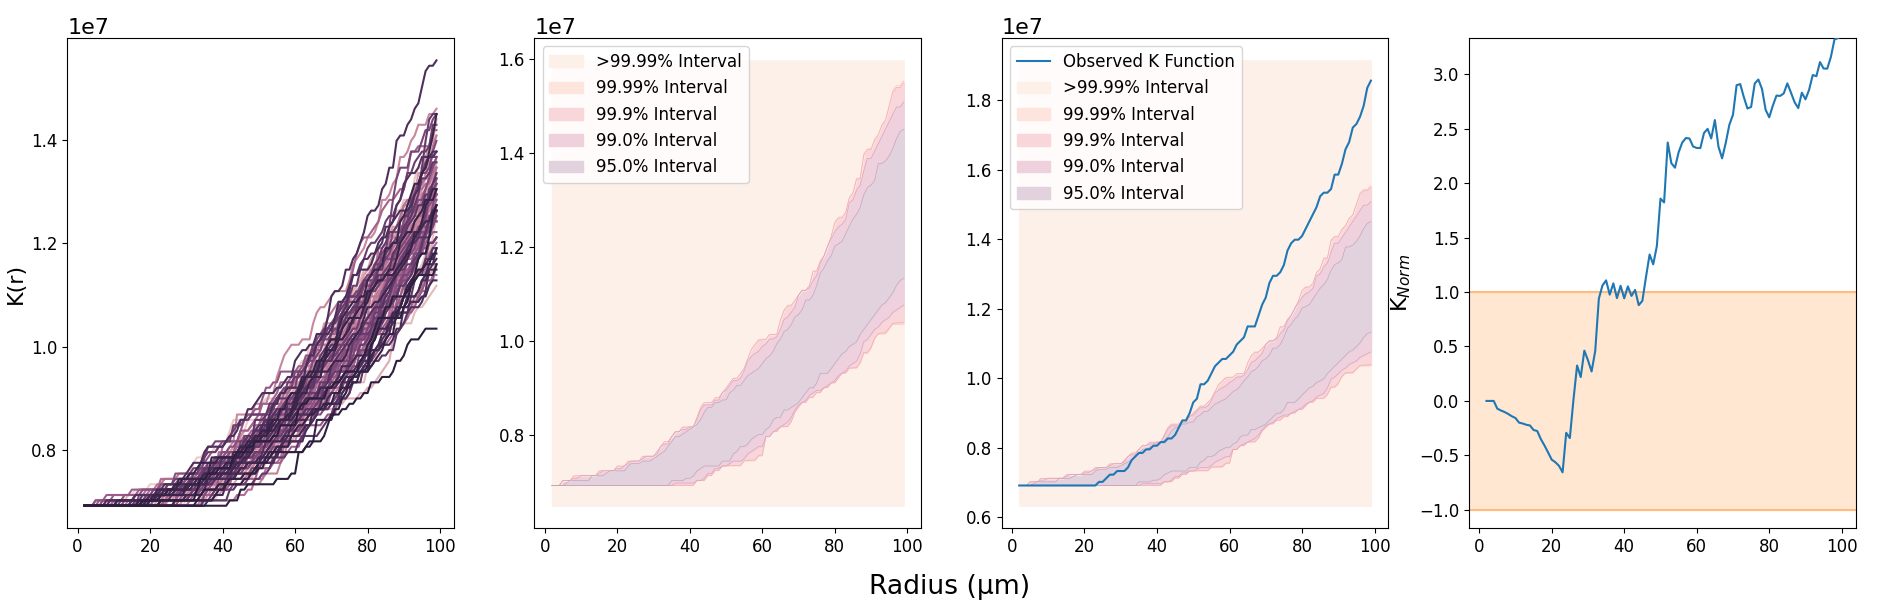

In [268]:
path = "/home/dkermany/ripley_results"
# path = "C:/Users/danie/Downloads/ripley_results"
plot_process(path)

In [20]:
def plot_individuals(rstats_path):
    def get_rstats_files(path):
        return glob(f"{path}/*.csv")

    def group_items(l, n=4):
        """Groups every 'n' items in the list into sublists."""
        return [l[i:i + n] for i in range(0, len(l), n)]

    def rearrange_sublists(lst, order):
        """Rearranges elements within each sublist of a list based on a specified order."""
        return [[sublist[i] for i in order] for sublist in lst]
        
    rstats_files = get_rstats_files(rstats_path)

    # filter our monte carlo results
    rstats_files = [os.path.splitext(os.path.basename(f))[0] for f in rstats_files if "random" not in f]
    u_rstats_files = [f for f in rstats_files if "univariate" in f]
    m_rstats_files = [f for f in rstats_files if "multivariate" in f]

    grouped_u_rstats_files = rearrange_sublists(group_items(sorted(u_rstats_files)), [2,1,0,3])
, alpha=0.2
    # Update the font size for the plot
    plt.rcParams.update({"font.size": 20})
    
    # Create a subplot with 3 rows and 1 column
    f, axes = plt.subplots(4,4, sharex=True, figsize=(15,15))
    # f.add_subplot(111, frameon=False)
    # plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    f.tight_layout(pad=1.5)

    f.supxlabel("Radius (μm)", y=0.00)
    f.supylabel("K$_{Norm}$", x=0.00)
    
    # Loop over each univariate filename
    for i, group in enumerate(grouped_u_rstats_files[4:]):
        for j, filename in enumerate(group):
            print(filename)
            # Construct the path for the CSV file
            fullpath = os.path.join(rstats_path, f"{filename}.csv")
            
            prefix, _, date, id, mode, label, _ = filename.split("_")
            
            # Construct the path for the random CSV file
            rand_fullpath = os.path.join(rstats_path, f"FV10__{date}_{id}_random_{mode}_{label}_rstats.csv")
            print(rand_fullpath)
    
            # Load the CSV file and random CSV file into DataFrames
            rstats = load_csv(fullpath)
            rand_rstats = load_csv(rand_fullpath)

            if i == 0:
                title=["Tumor", "NG2+", "Branches", "TVC"]
            else:
                title=[None]*4
    
            draw_normalized_graph(rstats, rand_rstats, ax=axes[i,j], title=title[j])
            # plt.savefig(os.path.join(rstats_path, "all_results", f"{filename}"))

    # plt.savefig("/home/dkermany/ripley_plots/S1_2.svg", bbox_inches="tight")

FV10__20181106_121902_univariate_tumor_rstats
/home/dkermany/ripley_results/FV10__20181106_121902_random_univariate_tumor_rstats.csv
      Unnamed: 0  Radius (r)          K(r)        L(r)        H(r)  Line
48            48          50  3.078296e+07  194.419836  144.419836   NaN
146          146          50  2.928135e+07  191.205695  141.205695   1.0
244          244          50  2.627813e+07  184.431586  134.431586   2.0
342          342          50  2.627813e+07  184.431586  134.431586   3.0
440          440          50  2.627813e+07  184.431586  134.431586   4.0
...          ...         ...           ...         ...         ...   ...
9358        9358          50  2.627813e+07  184.431586  134.431586  95.0
9456        9456          50  2.627813e+07  184.431586  134.431586  96.0
9554        9554          50  2.627813e+07  184.431586  134.431586  97.0
9652        9652          50  2.627813e+07  184.431586  134.431586  98.0
9750        9750          50  2.777974e+07  187.879702  137.8797

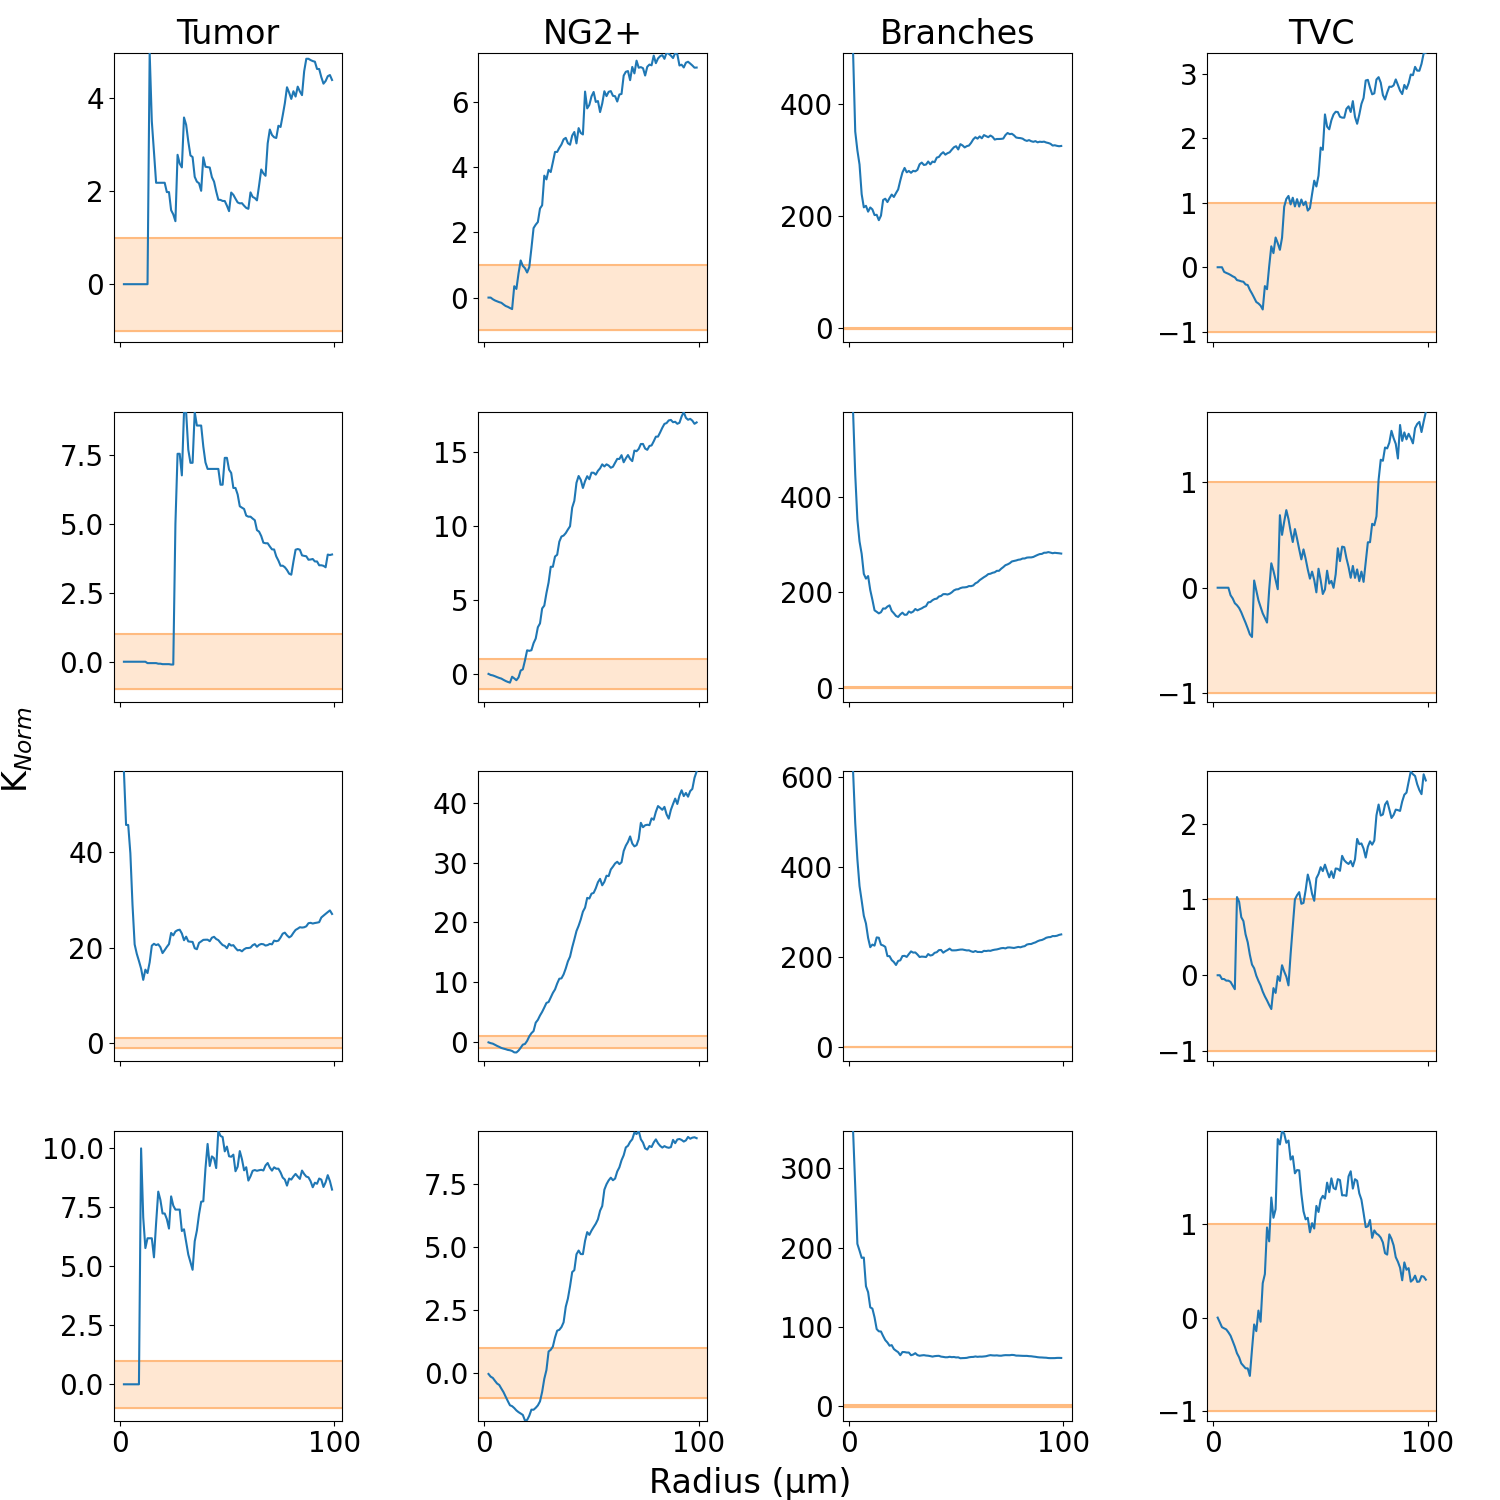

In [21]:
path = "/home/dkermany/ripley_results"
# path = "C:/Users/danie/Downloads/ripley_results"
plot_individuals(path)

In [ ]:
def draw_combined_graph(df, title=None):
    # Set the tick label format to plain
    plt.ticklabel_format(style="plain")


    # Update the font size for the plot
    plt.rcParams.update({"font.size": 20})

    
    # Create a subplot with 3 rows and 1 column
    # ax = plt.figure(figsize=(7,7))
    f, ax = plt.subplots(figsize=(7,7))
    
    # Plot the K(r) values for the data and the random data
    l_ax = sns.lineplot(data=df, x="Radius (r)", y="K_norm", hue="Sample", style="Sample", ax=ax, legend="brief", zorder=3)

    for line in plt.gca().get_lines():
        label = line.get_label()
        if label == "Average":
            line.set_alpha(1.0)
        else:
            line.set_alpha(0.5)

    if len(l_ax. lines) > 0:
        average_line = l_ax.lines[0]
        average_line.set_linewidth(2)
        average_line.set_alpha(1.0)
        average_line.set_zorder(5)
    
    # # Get the current x-axis limits after plotting the data
    # ax = plt.gca()
    xlims = ax.get_xlim()
    
    # Get the current y-axis limits after plotting the data
    ylims = ax.get_ylim()
    
    # Fill between y=1 and y=-1, extending to the edges of the graph
    ax.fill_between(xlims, -1, 1, color='#ffe5ce', alpha=0.9)
    
    # Adding thicker lines for the top and bottom borders, extending to the edges
    ax.hlines(1, *xlims, colors='#ffbb80', linewidth=1.5)
    ax.hlines(-1, *xlims, colors='#ffbb80', linewidth=1.5)
    
    # Set the x and y-axis limits to ensure the fill and borders extend to the edges
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    ax.set(xlabel="")
    ax.set(ylabel="")

    # Manually set the y-axis limits to include the -1 to 1 range
    max_val = max(df["K_norm"])
    min_val = min(df["K_norm"])
    
    new_ylims = (min(-1-(0.05*max_val), min_val), max(1+(0.05*max_val), max_val))  # This includes both your data and the -1 to 1 interval
    # print(rstats)
    # pprint(rand_rstats["K(r)"].tolist())
    print("new ylims", new_ylims)
    ax.set_ylim(new_ylims)

    plt.legend(prop={'size': 14})  # Set the font size to 10

    ax.title.set_text(title)


In [ ]:
def plot_combined_univariate(rstats_path):
    def get_rstats_files(path):
        return glob(f"{path}/*.csv")

    def group_items(l, n=4):
        """Groups every 'n' items in the list into sublists."""
        return [l[i:i + n] for i in range(0, len(l), n)]

    def rearrange_sublists(lst, order):
        """Rearranges elements within each sublist of a list based on a specified order."""
        return [[sublist[i] for i in order] for sublist in lst]
        
    rstats_files = get_rstats_files(rstats_path)

    # filter our monte carlo results
    rstats_files = [os.path.splitext(os.path.basename(f))[0] for f in rstats_files if "random" not in f]
    u_rstats_files = sorted([f for f in rstats_files if "univariate" in f])
    m_rstats_files = sorted([f for f in rstats_files if "multivariate" in f])


    types = ["tumor", "ng2", "branch", "tvc"]

    
    
    for t in types:
        t_files = [i for i in u_rstats_files if t in i]

        df = pd.DataFrame()
        df["Radius (r)"] = pd.Series(np.arange(2,100))
        for i, filename in enumerate(t_files):
            # print(filename)
            # Construct the path for the CSV file
            fullpath = os.path.join(rstats_path, f"{filename}.csv")
            prefix, _, date, id, mode, label, _ = filename.split("_")
            
            # Construct the path for the random CSV file
            rand_fullpath = os.path.join(rstats_path, f"FV10__{date}_{id}_random_{mode}_{label}_rstats.csv")
    
            # Load the CSV file and random CSV file into DataFrames
            rstats = load_csv(fullpath)
            rand_rstats = load_csv(rand_fullpath)

            K_norm = normalize(rstats, rand_rstats)
            df[f"Sample {i+1}"] = pd.Series(K_norm)

        df['Average'] = df.drop('Radius (r)', axis=1).mean(axis=1)
        # print(df)
        # for r in df["Radius (r)"]:
        #     print(df[df["Radius (r)"] == r])
            
        #     break
            

        df_long = pd.melt(df, id_vars=["Radius (r)"], value_vars=["Average"]+[f"Sample {i+1}" for i in range(8)],
                          var_name="Sample", value_name="K_norm")
        # print(df_long)
        print(t)
        draw_combined_graph(df_long, title=t)

tumor
new ylims (-3.8476492699230316, 56.952985398460626)
ng2
new ylims (-3.2624314028103467, 45.24862805620693)
branch
new ylims (-33.6272329418145, 652.54465883629)
tvc
new ylims (-1.1665386107030329, 3.3307722140606577)


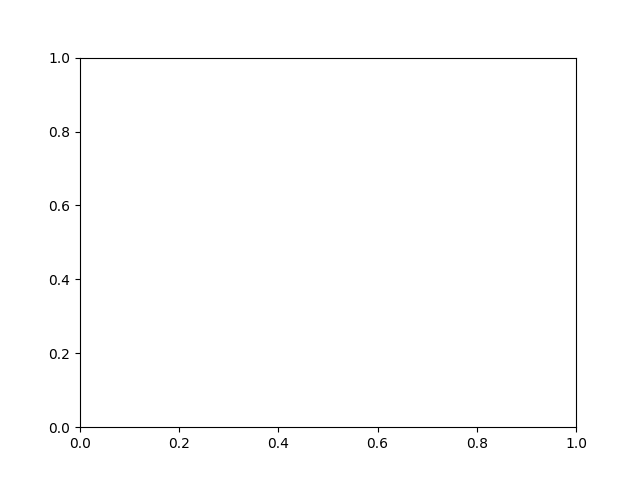

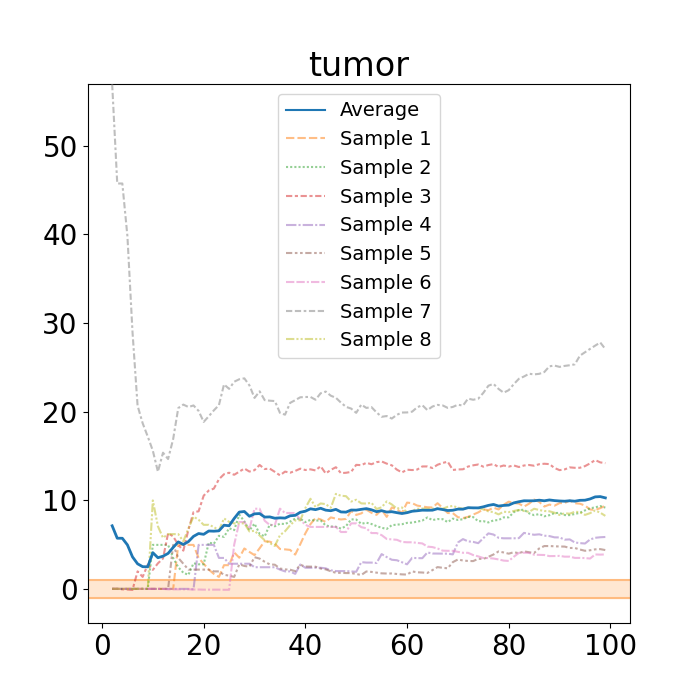

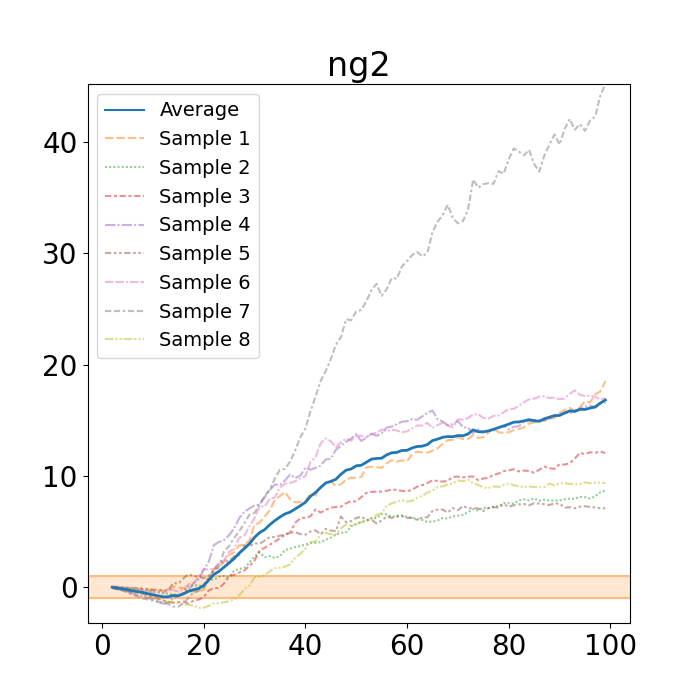

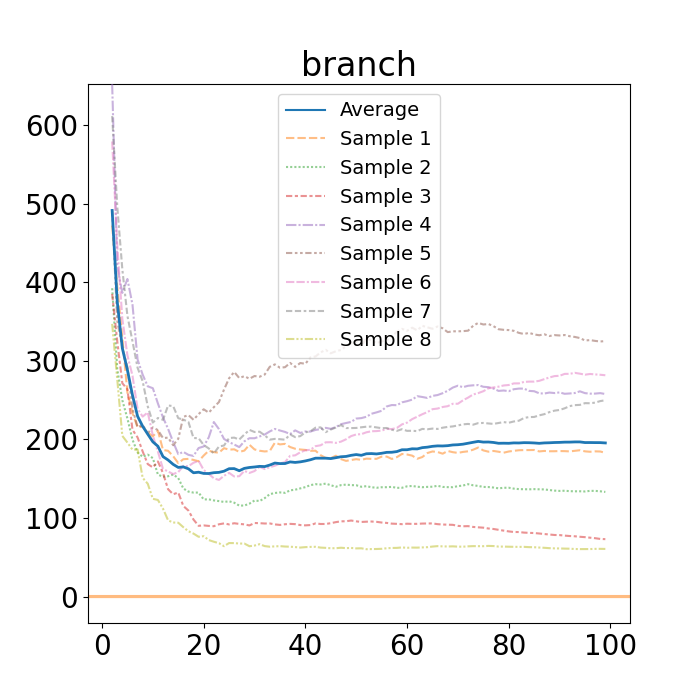

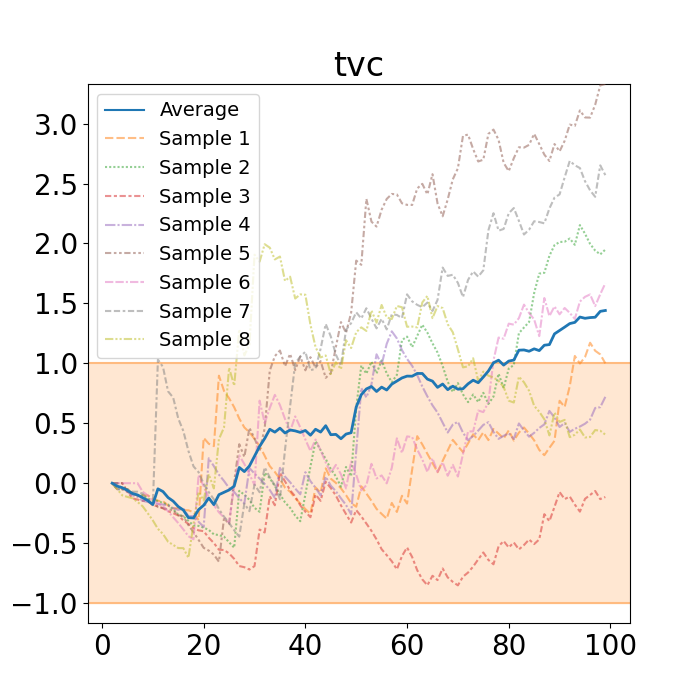

In [ ]:
# path = "/home/dkermany/ripley_results"
path = "C:/Users/danie/Downloads/ripley_results"
plot_combined_univariate(path)

In [ ]:
def plot_combined_multivariate(rstats_path):
    def get_rstats_files(path):
        return glob(f"{path}/*.csv")

    def group_items(l, n=4):
        """Groups every 'n' items in the list into sublists."""
        return [l[i:i + n] for i in range(0, len(l), n)]

    def rearrange_sublists(lst, order):
        """Rearranges elements within each sublist of a list based on a specified order."""
        return [[sublist[i] for i in order] for sublist in lst]
        
    rstats_files = get_rstats_files(rstats_path)

    # filter our monte carlo results
    rstats_files = [os.path.splitext(os.path.basename(f))[0] for f in rstats_files if "random" not in f]
    m_rstats_files = sorted([f for f in rstats_files if "multivariate" in f])

    anchor = ["tumor", "ng2"]
    types = ["ng2", "branch", "tvc"]
    titles = ["Tumor-NG2 Relationship", "Tumor-Branch Relationship", "Tumor-Tortuous Vessel Relationship", "NG2-Branch Relationship",
              "NG2-Tortuous Vessel Relationship"]
    # pprint(m_rstats_files)
    i_cnt = 0
    for a in anchor:
        for t in types:
            if a != t: 
                a_files = [i for i in m_rstats_files if a in i and t in i]
                # pprint(a_files)
                # break

                df = pd.DataFrame()
                df["Radius (r)"] = pd.Series(np.arange(2,100))
                for i, filename in enumerate(a_files):
                    # print(filename)
                    # Construct the path for the CSV file
                    fullpath = os.path.join(rstats_path, f"{filename}.csv")
                    prefix, _, date, id, mode, anchor, target, _ = filename.split("_")
            
                    # Construct the path for the random CSV file
                    rand_fullpath = os.path.join(rstats_path, f"FV10__{date}_{id}_random_{mode}_{anchor}_{target}_rstats.csv")
            
                    # Load the CSV file and random CSV file into DataFrames
                    rstats = load_csv(fullpath)
                    rand_rstats = load_csv(rand_fullpath)
        
                    K_norm = normalize(rstats, rand_rstats)
                    df[f"Sample {i+1}"] = pd.Series(K_norm)

                df['Average'] = df.drop('Radius (r)', axis=1).mean(axis=1)
                # print(df)
                # for r in df["Radius (r)"]:
                #     print(df[df["Radius (r)"] == r])
                    
                #     break
                    
        
                df_long = pd.melt(df, id_vars=["Radius (r)"], value_vars=["Average"]+[f"Sample {i+1}" for i in range(8)],
                                  var_name="Sample", value_name="K_norm")
                # print(df_long)
                print(t)
                draw_combined_graph(df_long, title=titles[i_cnt])
                i_cnt += 1

ng2
new ylims (-9.425785904681405, 7.0567528841644425)
branch
new ylims (-10.384198044438989, 0.9667034482944772)
tvc
new ylims (-5.877491426823746, 1.0466219674902815)
branch
new ylims (-22.47479033942168, 1.0066723062274074)
tvc
new ylims (-7.954156367325116, 3.75719871541585)


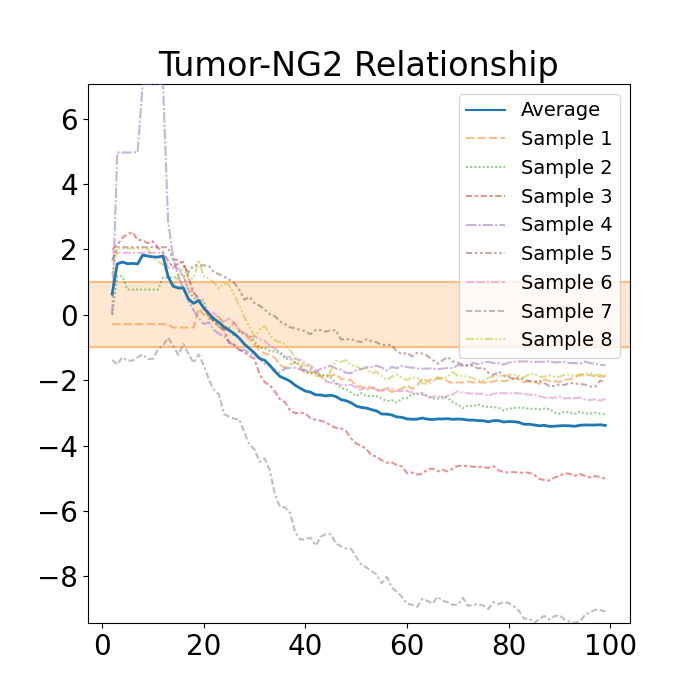

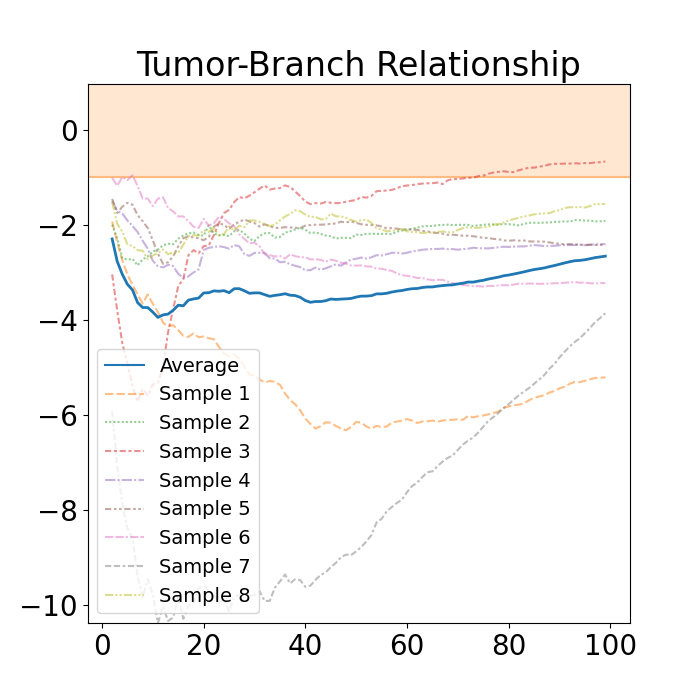

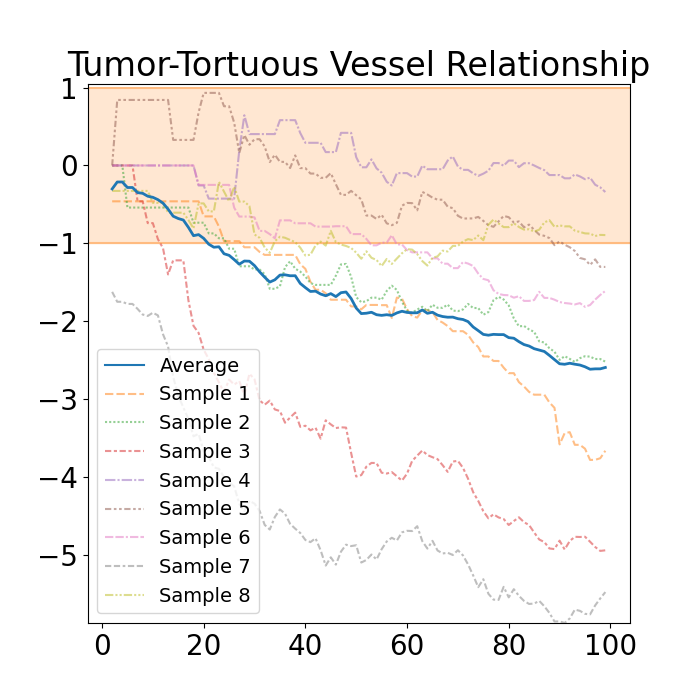

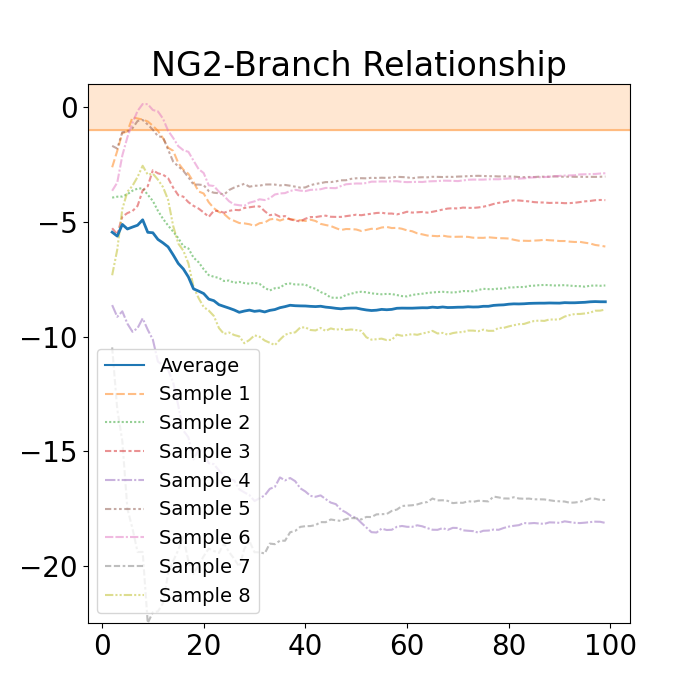

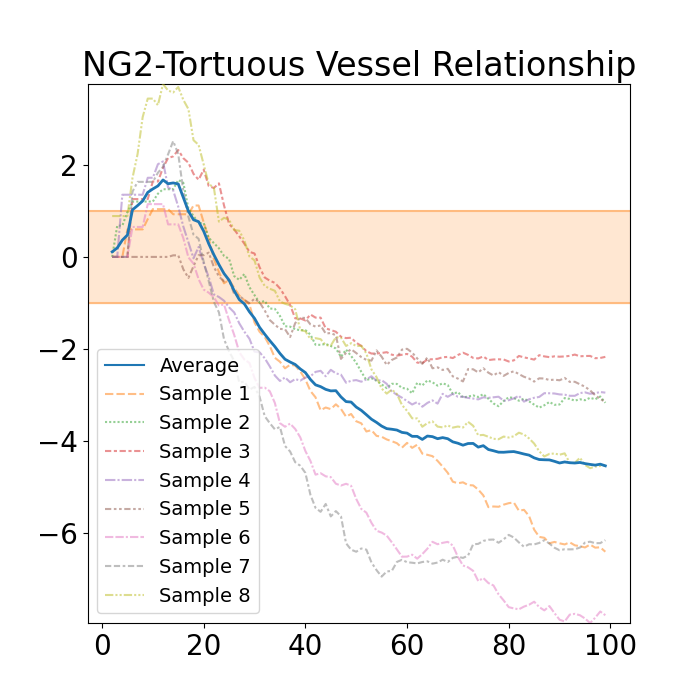

In [ ]:
# path = "/home/dkermany/ripley_results"
path = "C:/Users/danie/Downloads/ripley_results"
plot_combined_multivariate(path)

In [ ]:
!ls /home/dkermany/ripley_results

boundary_corrected
FV10__20181004_122358_multivariate_ng2_branch_rstats.csv
FV10__20181004_122358_multivariate_ng2_tvc_rstats.csv
FV10__20181004_122358_multivariate_tumor_branch_rstats.csv
FV10__20181004_122358_multivariate_tumor_ng2_rstats.csv
FV10__20181004_122358_multivariate_tumor_tvc_rstats.csv
FV10__20181004_122358_random_multivariate_ng2_branch_rstats.csv
FV10__20181004_122358_random_multivariate_ng2_tvc_rstats.csv
FV10__20181004_122358_random_multivariate_tumor_branch_rstats.csv
FV10__20181004_122358_random_multivariate_tumor_ng2_rstats.csv
FV10__20181004_122358_random_multivariate_tumor_tvc_rstats.csv
FV10__20181004_122358_random_univariate_branch_rstats.csv
FV10__20181004_122358_random_univariate_ng2_rstats.csv
FV10__20181004_122358_random_univariate_tumor_rstats.csv
FV10__20181004_122358_random_univariate_tvc_rstats.csv
FV10__20181004_122358_univariate_branch_rstats.csv
FV10__20181004_122358_univariate_ng2_rstats.csv
FV10__20181004_122358_univariate_tumor_rstats.csv
FV10__20

In [ ]:
!aws --version

aws-cli/1.25.45 Python/3.8.10 Linux/5.13.0-48-generic botocore/1.27.45
